In [ ]:
# same python imports as in quad_model in lenstronomy_extensions
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF


In [2]:
!ls rung0/code1/f160w-seed3/drizzled_image/

lens-image.fits      lens-image.fits.coo.2  psf.fits
lens-image.fits.coo  noise_map.fits	    pyraf


/home/hiparco/anaconda3/envs/lenstronomy/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


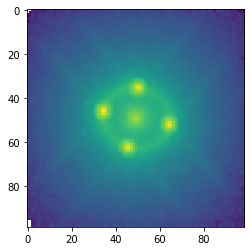

In [3]:
from astropy.utils.data import download_file
from astropy.io import fits

path = 'rung0/code1/f160w-seed3/'

im_lens = []
im_psf = []
for i in range(1,9):
    im_lens.append(fits.getdata(path+"non_drizzled-lens-image-"+str(i)+".fits"))
    im_psf.append(fits.getdata(path+"non_drizzled_psf-"+str(i)+".fits"))
#plt.imshow(test[0].data,cmap = 'gray')
    
di_lens = fits.getdata(path+'/drizzled_image/lens-image.fits')    
di_psf = fits.getdata(path+'/drizzled_image/psf.fits')    
di_noise = fits.getdata(path+'/drizzled_image/noise_map.fits')    

im_lens = np.array(im_lens)
im_psf = np.array(im_psf)

plt.imshow(np.log10(di_lens))

[ 0.08344 -1.16368  1.21312 -0.2808 ] [-1.09728 -0.24696  0.22808  1.06184]


/home/hiparco/anaconda3/envs/lenstronomy/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


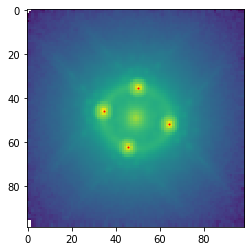

In [27]:
#A las coordenadas de daofind toca restarles 1.
coordinates = np.loadtxt(path+'/drizzled_image/lens-image.fits.coo')-1
pos_lens = coordinates[-1][0:2] #posición x,y del pico central.
coordinates = coordinates[0:-1]

#Condiciones iniciales para la RA y DEC. Este es otro parámetro a ajustar.
initial_ra = 0.00
initial_dec = 0.00

#Transformación lineal con pendiente 0.08 arcseg/pixel e intercepto tal que:
# initial_ra + initial_dec = 0.08 * (pos_lens.sum()) + 2*b
def lens_centered_coordinates(coordinate):
    return 0.08*coordinate+0.5*(initial_dec+initial_ra-0.08*(pos_lens.sum()))

plt.scatter(coordinates[:,0], coordinates[:,1], s=1, color = 'r')

x_image = lens_centered_coordinates(coordinates[:,0])
y_image = lens_centered_coordinates(coordinates[:,1])
print(x_image,y_image)
plt.imshow(np.log10(di_lens))

In [61]:
#Ahora, preparar los kwargs.

numPix = 99
deltaPix = 0.08
exp_time = 50 #tomado del paper del challenge: 9600s en total, 1200s por imagen.
background_rms = 0.4

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

# subimos las imagenes mediante la rutina update date, de imaging data.
data_class.update_data(di_lens)
kwargs_data['image_data'] = di_lens

psf_fwhm = 2.20

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': deltaPix, 'truncation': 8}
psf_class = PSF(**kwargs_psf)





lens_model_list = ['SPEP', 'SHEAR_GAMMA_PSI']
lens_light_model_list = ['SERSIC' ]
source_model_list = ['SERSIC_ELLIPSE']
point_source_list = ['LENSED_POSITION']


In [62]:
kwargs_model = {'lens_model_list': lens_model_list,
                               'source_light_model_list': source_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               'additional_images_list': [False],
                               'fixed_magnification_list': [False],
                             }
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                              'num_point_source_list': [4],
                              'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER', 'NONE'
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'position_uncertainty': 0.004,
                             'check_solver': False,
                             'solver_tolerance': 0.0001,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [63]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma_ext': 0.01, 'psi_ext': 0.}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image+0.01, 'dec_image': y_image-0.01}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.2, 'e1': 0.15, 'e2': 0.15, 'gamma': .15, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma_ext': 0.1, 'psi_ext': np.pi}]
kwargs_source_sigma = [{'R_sersic': 0.05, 'n_sersic': .25, 'center_x': .1, 'center_y': 0.1, 'e1': 0.1, 'e2': 0.1}]
kwargs_lens_light_sigma = [{'R_sersic': 0.05, 'n_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.005] * 4, 'dec_image': [0.005] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma_ext': 0., 'psi_ext': -np.pi}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -1 * np.ones_like(x_image), 'dec_image': -1 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma_ext': 0.3, 'psi_ext': np.pi}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 2, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 1 * np.ones_like(x_image), 'dec_image': 1 * np.ones_like(y_image)}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}], kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 0.1, 'n_particles': 100, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 10, 'n_run': 10, 'walkerRatio': 4, 'sigma_scale': .01}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
converged after 59 iterations!
best fit found:  -1000000000000000 [2.0, 0.01, 0.0, 0.03, 1.0, 0, 0, 0.1, 1, 0, 0, 0.09343999999999995, -1.1536800000000003, 1.2231199999999995, -0.27080000000000015, -1.1072800000000005, -0.2569600000000005, 0.21807999999999983, 1.0518399999999997]
-204582651391.16202 reduced X^2 of best position
-1000000000000000 logL
9776 effective number of data points
[{'theta_E': 1.1547134576385494, 'gamma': 2.0, 'e1': -0.04526935662502435, 'e2': -0.011634747500396706, 'center_x': 0.009840540738677388, 'center_y': -0.006881746743374183}, {'gamma_ext': 0.01, 'psi_ext': 13.449958351120863, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.03, 'n_sersic': 1.0, 'e1': 0, 'e2': 0, 'center_x': 0.0316638670537502, 'center_y': -0.006163434665445465}] source result
[{'amp': 1, 'R_sersic': 0.1, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}] lens light result
[{'ra_image': array([ 0.09344, -1.15368,  1.22312, -0.2708 ]), 'dec_imag

-11.282699286508766 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  3.820636089862276
(19, ['gamma_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image'])


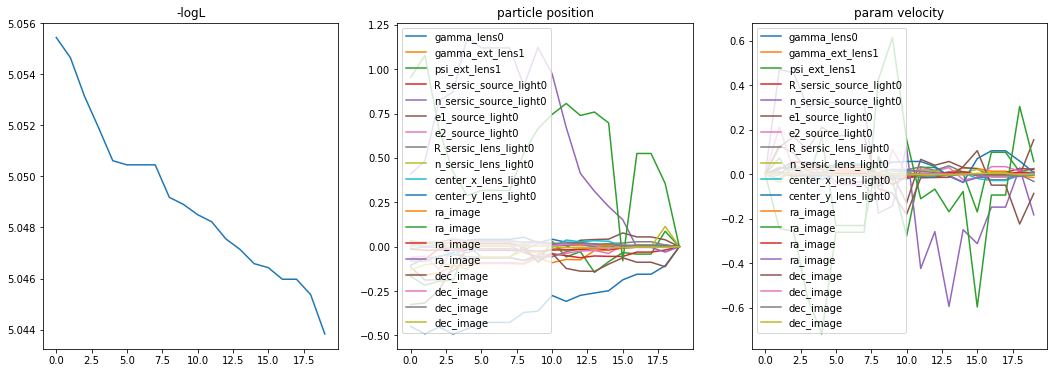

<Figure size 432x288 with 0 Axes>

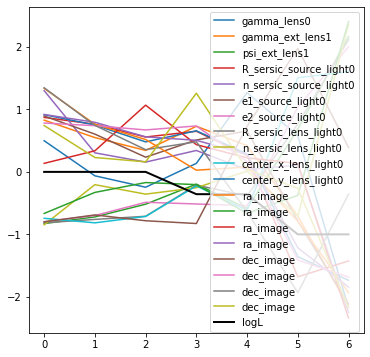

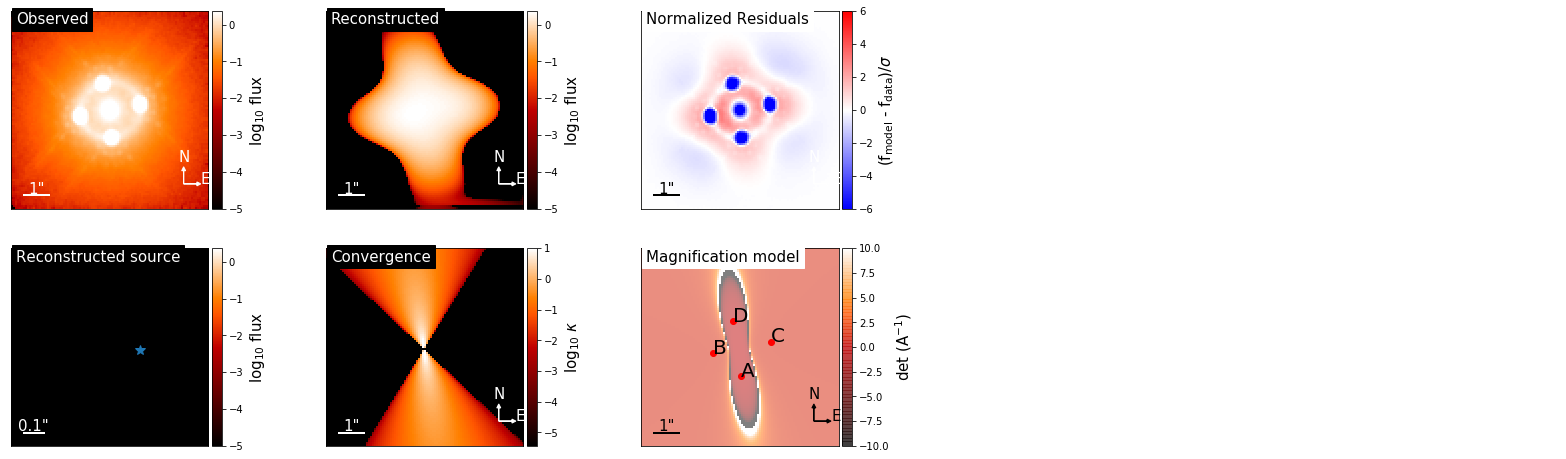

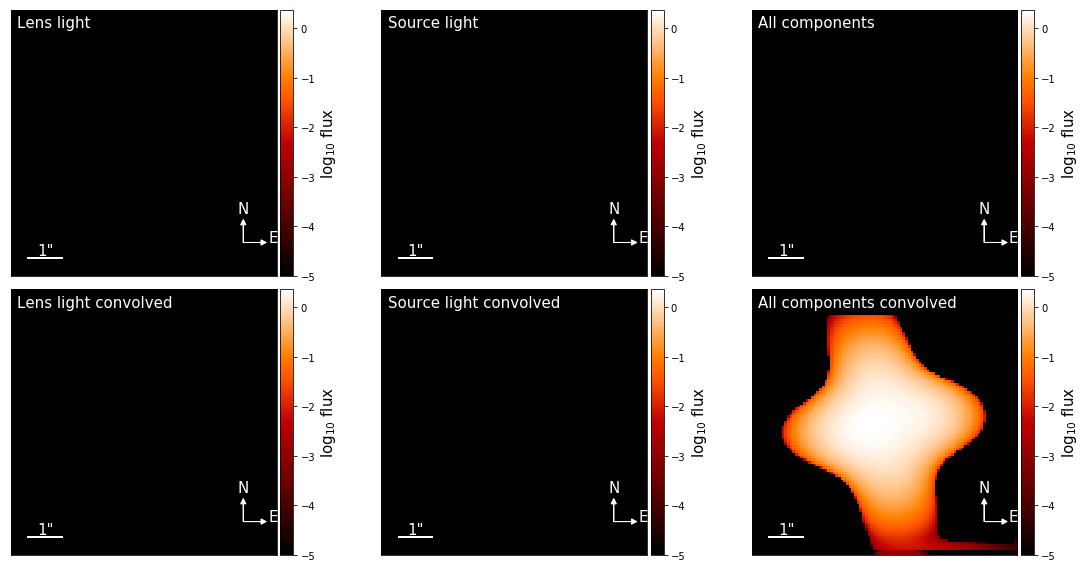

{'kwargs_lens': [{'theta_E': 1.419335711575219, 'gamma': 2.328964325551177, 'e1': -0.44721624400168525, 'e2': -0.12089617166829233, 'center_x': -0.04182987441902308, 'center_y': -0.08182508621078331}, {'gamma_ext': 0.29871072638689306, 'psi_ext': 1.6468622866018134, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -226962.835142652, 'R_sersic': 0.19864470997149686, 'n_sersic': 0.6871316057423782, 'e1': 0.30059549514992856, 'e2': 0.13060289342353554, 'center_x': 0.15326494671612523, 'center_y': -0.014870815790030877}], 'kwargs_lens_light': [{'amp': -1914.5747368304937, 'R_sersic': 0.20657468940120008, 'n_sersic': 1.7637996726404954, 'center_x': -0.039991104109305904, 'center_y': 1.0661970132649767}], 'kwargs_ps': [{'ra_image': array([ 0.0587379 , -1.07881482,  1.23408767, -0.25477832]), 'dec_image': array([-1.17578172, -0.25684194,  0.19723044,  1.02144198]), 'point_amp': array([14180.46207085, 51818.43941062, 50620.71219335, 16826.27363542])}], 'kwargs_special': {}, 'kwargs_extinctio

In [67]:
from lenstronomy.Plots.output_plots import ModelPlot
import lenstronomy.Plots.output_plots as out_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

param_class = fitting_seq.param_class
print(param_class.num_param())
#print(chain_list)

for i in range(len(chain_list)):
    out_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(16, 8),
                       sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
#f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

In [68]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma_ext': 0.01, 'psi_ext': 0.}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image+0.01, 'dec_image': y_image-0.01}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma_ext': 0.1, 'psi_ext': np.pi}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma_ext': 0., 'psi_ext': -np.pi}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma_ext': 0.3, 'psi_ext': np.pi}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}], kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 10, 'n_run': 10, 'walkerRatio': 4, 'sigma_scale': .1}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
max iteration reached! stoping
-11.253402704384733 reduced X^2 of best position
-55006.632419032576 logL
9776 effective number of data points
[{'theta_E': 0.9381028375459266, 'gamma': 2.3301663916162183, 'e1': 0.48040071783424476, 'e2': 0.2721407622052834, 'center_x': 0.23151612154744122, 'center_y': 0.034694660061728846}, {'gamma_ext': 0.29814710696816576, 'psi_ext': -2.834879750632295, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.036523460578788726, 'n_sersic': 1.3415071239567549, 'e1': 0.039694200407299825, 'e2': -0.20876391182116458, 'center_x': -0.02528443925069439, 'center_y': 0.1557391655311653}] source result
[{'amp': 1, 'R_sersic': 0.01472668589145024, 'n_sersic': 0.6357137689955765, 'center_x': -0.009227995078665322, 'center_y': -0.03475359350775152}] lens light result
[{'ra_image': array([ 0.11532082, -0.54846917,  0.7178209 , -0.18885941]), 'dec_image': array([-0.68

-11.224697973478742 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  3.7820569652550446
(19, ['gamma_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image'])


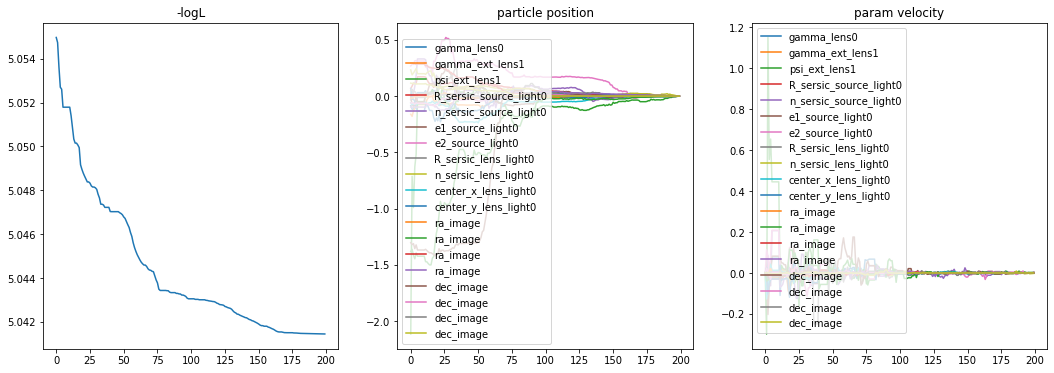

<Figure size 432x288 with 0 Axes>

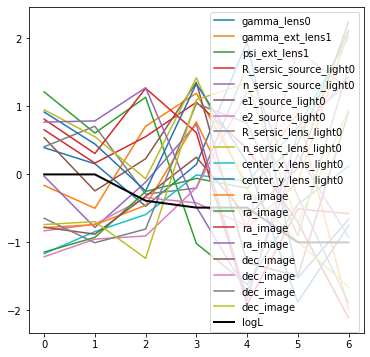

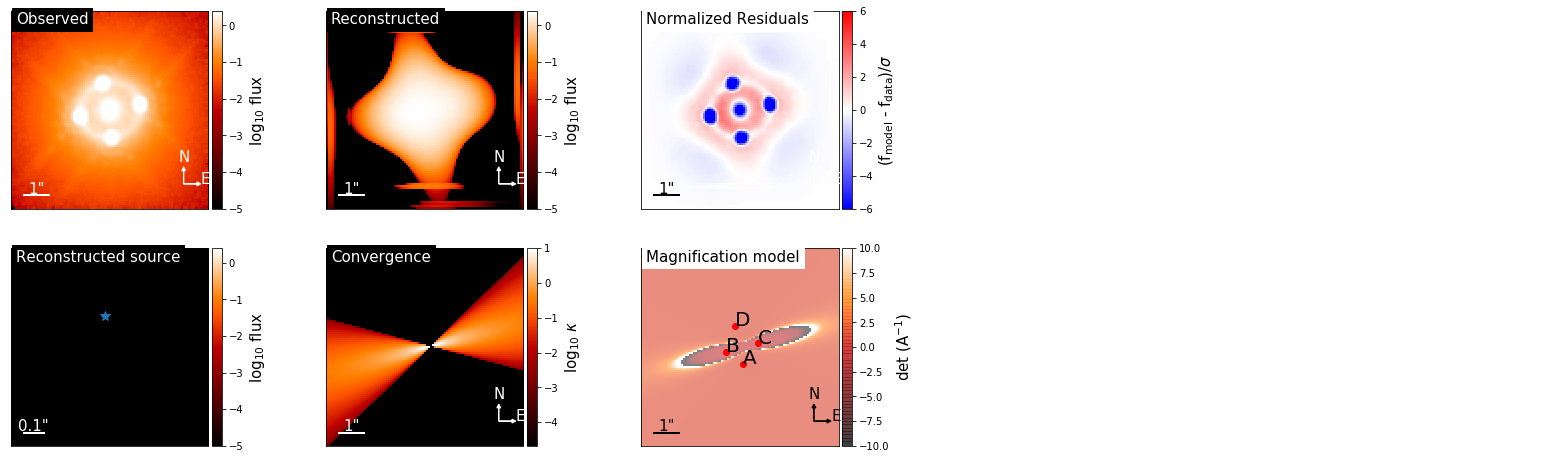

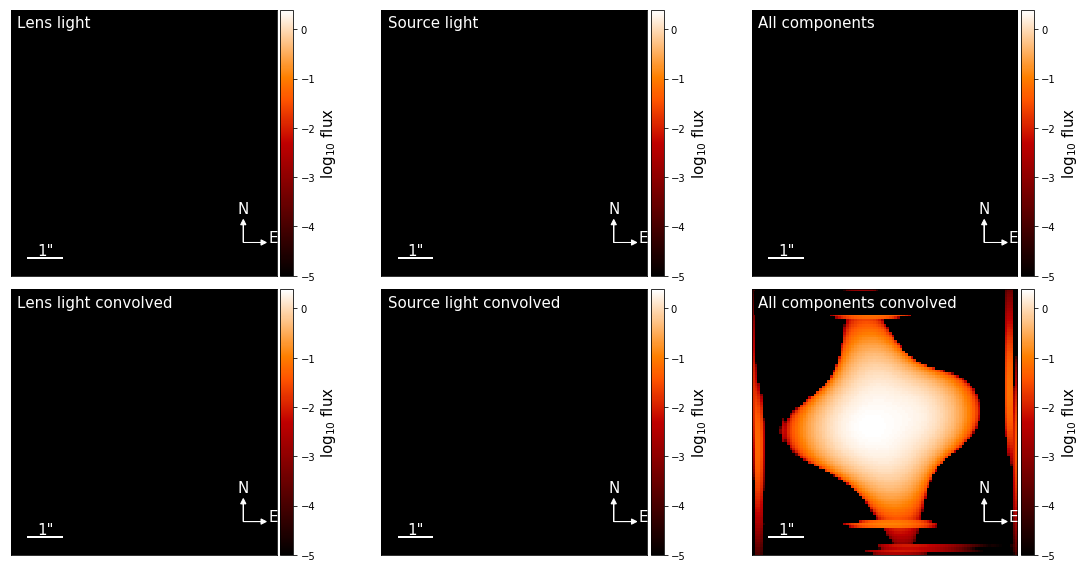

{'kwargs_lens': [{'theta_E': 0.9381028375459266, 'gamma': 2.3301663916162183, 'e1': 0.48040071783424476, 'e2': 0.2721407622052834, 'center_x': 0.23151612154744122, 'center_y': 0.034694660061728846}, {'gamma_ext': 0.29814710696816576, 'psi_ext': -2.834879750632295, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -113580736.46555918, 'R_sersic': 0.036523460578788726, 'n_sersic': 1.3415071239567549, 'e1': 0.039694200407299825, 'e2': -0.20876391182116458, 'center_x': -0.02528443925069439, 'center_y': 0.1557391655311653}], 'kwargs_lens_light': [{'amp': -66142025.09752746, 'R_sersic': 0.01472668589145024, 'n_sersic': 0.6357137689955765, 'center_x': -0.009227995078665322, 'center_y': -0.03475359350775152}], 'kwargs_ps': [{'ra_image': array([ 0.11532082, -0.54846917,  0.7178209 , -0.18885941]), 'dec_image': array([-0.68090548, -0.20711539,  0.14256005,  0.84077054]), 'point_amp': array([401203.71277392,  73533.9061788 ,  47477.39394444, 511156.00647023])}], 'kwargs_special': {}, 'kwargs_ext

In [70]:
from lenstronomy.Plots.output_plots import ModelPlot
import lenstronomy.Plots.output_plots as out_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

param_class = fitting_seq.param_class
print(param_class.num_param())
#print(chain_list)

for i in range(len(chain_list)):
    out_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(16, 8),
                       sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
#f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)